In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tp2datostrain/train.csv
/kaggle/input/tp2datostrain/test.csv
/kaggle/input/pingsound/PING - Sound effect.mp3


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import CountEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


In [3]:
from IPython.display import Audio
sound_file = '/kaggle/input/pingsound/PING - Sound effect.mp3'
def ping():
    display(Audio(sound_file, autoplay=True))

In [4]:
import pandas as pd
test = pd.read_csv("../input/tp2datostrain/test.csv")
train = pd.read_csv("../input/tp2datostrain/train.csv")

In [5]:
dfCheto = pd.concat([train,test], sort=False)
dfCheto['precio'] = SimpleImputer(strategy='median').fit_transform(dfCheto[['precio']])
df = dfCheto.copy()


In [6]:
ciudades = list(dfCheto["ciudad"].unique())
tipos_de_propiedad = list(dfCheto["tipodepropiedad"].unique())
provincia = list(dfCheto["provincia"].unique())
categorias  = [provincia, tipos_de_propiedad, ciudades]

In [7]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [8]:
df.provincia.isna().sum()

197

In [9]:
aux2 = dfCheto[['ciudad', 'provincia']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby(['provincia']).agg(lambda x:x.provincia.value_counts().index[0]).reset_index().set_index('ciudad')
dicc_ciudadPorPcia = aux2.T.to_dict('records').copy()[0]
dicc_ciudadPorPcia['CUALQUIERA'] = 'CUALQUIERCIUDAD'
df['ciudad'] =df['ciudad'].fillna('CUALQUIERA')
df['provincia'] = df['provincia'].fillna(df['ciudad'].map(dicc_ciudadPorPcia))

In [10]:
df.provincia.fillna('provinciaVacia',inplace=True)

In [11]:
df['provincia'].isna().sum()

0

In [12]:
aux2 = dfCheto[['ciudad', 'provincia']].copy()
aux2 = aux2.groupby(['provincia']).agg(lambda x:x.provincia.value_counts().index[0]).reset_index().set_index('ciudad')
aux2.head()
dicc_ciudadMasFrecuentePorPcia = aux2.T.to_dict('records').copy()[0]
dicc_invertido = dict(map(reversed, dicc_ciudadMasFrecuentePorPcia.items()))
df.ciudad.fillna(df.provincia.map(dicc_invertido),inplace=True);
df.ciudad.isna().sum()

0

In [13]:
df.ciudad.fillna('ciudadVacia',inplace=True)

In [14]:
df.tipodepropiedad.fillna('tipoVacio',inplace=True)
'''
auxmetros = df[['tipodepropiedad','metrostotales']].copy()
auxmetros = auxmetros.groupby('tipodepropiedad')['metrostotales'].mean().sort_values().reset_index()
lista = sorted(auxmetros.metrostotales.tolist())
lista_2 = [0]*len(lista)
for i,numero in enumerate(lista):
    if i == 0: lista_2[i] = (0,numero)
    else:
        lista_2[i] = (lista[i-1],lista[i])
rangoMetros = pd.Series(lista_2).sort_values()
auxmetros['rangoMetros'] = rangoMetros
auxmetros = auxmetros.set_index('tipodepropiedad').drop(columns='metrostotales')
dicc_tipoDeProp = auxmetros.T.to_dict('records').copy()[0]
def mapearMetros(metrostotales,dicc_tipoDeProp):
    for clave in dicc_tipoDeProp:
        if metrostotales >= dicc_tipoDeProp[clave][0] and metrostotales < dicc_tipoDeProp[clave][1]: return clave
    return 'Casa'
df.tipodepropiedad.fillna(df.metrostotales.map(lambda x: mapearMetros(x,dicc_tipoDeProp)),inplace=True);
df.tipodepropiedad.isna().sum()
'''

"\nauxmetros = df[['tipodepropiedad','metrostotales']].copy()\nauxmetros = auxmetros.groupby('tipodepropiedad')['metrostotales'].mean().sort_values().reset_index()\nlista = sorted(auxmetros.metrostotales.tolist())\nlista_2 = [0]*len(lista)\nfor i,numero in enumerate(lista):\n    if i == 0: lista_2[i] = (0,numero)\n    else:\n        lista_2[i] = (lista[i-1],lista[i])\nrangoMetros = pd.Series(lista_2).sort_values()\nauxmetros['rangoMetros'] = rangoMetros\nauxmetros = auxmetros.set_index('tipodepropiedad').drop(columns='metrostotales')\ndicc_tipoDeProp = auxmetros.T.to_dict('records').copy()[0]\ndef mapearMetros(metrostotales,dicc_tipoDeProp):\n    for clave in dicc_tipoDeProp:\n        if metrostotales >= dicc_tipoDeProp[clave][0] and metrostotales < dicc_tipoDeProp[clave][1]: return clave\n    return 'Casa'\ndf.tipodepropiedad.fillna(df.metrostotales.map(lambda x: mapearMetros(x,dicc_tipoDeProp)),inplace=True);\ndf.tipodepropiedad.isna().sum()\n"

In [15]:
aux2 = dfCheto[['idzona', 'ciudad']].copy()
aux2.dropna(inplace = True)
aux2 = aux2.groupby('ciudad').agg({'idzona':'median'})
ids = aux2.T.to_dict('records').copy()
ids = ids[0]
#df.idzona.fillna(df.ciudad.map(ids), inplace = True)

In [16]:
df['idzona'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['idzona']])

In [17]:
aux = dfCheto[['lat', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lat':'mean'})
lats = aux.T.to_dict('records').copy()
lats = lats[0]
#df.lat.fillna(df.ciudad.map(lats), inplace = True)

In [18]:
df['lat'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['lat']])

In [19]:
aux = dfCheto[['lng', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'lng':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
#df.lng.fillna(df.ciudad.map(lngs), inplace = True)

In [20]:
df['lng'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['lng']])

In [21]:
aux = dfCheto[['tipodepropiedad', 'habitaciones']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'habitaciones':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
#df.habitaciones.fillna(df.tipodepropiedad.map(habts), inplace = True)

In [22]:
df['habitaciones'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['habitaciones']])

In [23]:
aux = dfCheto[['tipodepropiedad', 'garages']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'garages':'median'})
habts = aux.T.to_dict('records').copy()
habts = habts[0]
#df.garages.fillna(df.tipodepropiedad.map(habts), inplace = True)

In [24]:
df.garages.fillna(0, inplace=True)

In [25]:
df.drop(columns=['direccion'], inplace=True)

In [26]:
aux = dfCheto[['antiguedad', 'ciudad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('ciudad').agg({'antiguedad':'mean'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
#df.antiguedad.fillna(df.ciudad.map(lngs), inplace = True)

In [27]:
df['antiguedad'] = SimpleImputer(strategy='most_frequent').fit_transform(df[['antiguedad']])

In [28]:
aux = dfCheto[['banos', 'tipodepropiedad']].copy()
aux.dropna(inplace = True)
aux = aux.groupby('tipodepropiedad').agg({'banos':'median'})
lngs = aux.T.to_dict('records').copy()
lngs = lngs[0]
#df.banos.fillna(df.tipodepropiedad.map(lngs), inplace = True)

In [29]:
df.banos.fillna(1, inplace=True)

In [30]:
aux = df.copy()

In [31]:
aux.metrostotales.fillna(0, inplace=True)
aux.metroscubiertos.fillna(0, inplace =True)
aux['metrostotalesCorregidos'] = aux[['metrostotales', 'metroscubiertos']].max(axis=1)
aux['metroscubiertosCorregidos'] = aux[['metrostotales', 'metroscubiertos']].min(axis=1)
df['metrostotales'] = aux['metrostotalesCorregidos']
df['metroscubiertos'] = aux['metroscubiertosCorregidos']

In [32]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['dia'] = df.fecha.dt.day
df['mes'] = df.fecha.dt.month
df['anio'] = df.fecha.dt.year
df.drop(columns=['fecha'], inplace=True)

In [33]:
df['publicacionesPorCiudad'] = CountEncoder().fit_transform(df['ciudad'])

In [34]:
df['publicacionesPorProvincia'] = CountEncoder().fit_transform(df['provincia'])

In [35]:
df['publicacionesPorTipo'] = CountEncoder().fit_transform(df['tipodepropiedad'])
df['publicacionesPorZona'] = CountEncoder().fit_transform(df['idzona'])
df['publicacionesPorBanos'] = CountEncoder().fit_transform(df['banos'])
df['publicacionesPorHabitaciones'] = CountEncoder().fit_transform(df['habitaciones'])
df['publicacionesPorAntiguedad'] = CountEncoder().fit_transform(df['antiguedad'])

In [36]:
df[['tipodepropiedad','provincia','ciudad']].isna().sum()

tipodepropiedad    0
provincia          0
ciudad             0
dtype: int64

### Datos por grupo

In [112]:
df['promedioAntiguedadZona'] = df.groupby('idzona')['antiguedad'].transform(np.mean)
df['promedioAntiguedadCiudad'] = df.groupby('ciudad')['antiguedad'].transform(np.mean)
df['promedioHabitacionesZona'] = df.groupby('idzona')['habitaciones'].transform(np.mean)
df['promedioHabitacionesCiudad'] = df.groupby('ciudad')['habitaciones'].transform(np.mean)
df['promedioMetrosCubiertosZona'] = df.groupby('idzona')['metroscubiertos'].transform(np.mean)
df['promedioMetrosCubiertosCiudad'] = df.groupby('ciudad')['metroscubiertos'].transform(np.mean)
df['promedioMetrosTotalesZona'] = df.groupby('idzona')['metrostotales'].transform(np.mean)
df['promedioMetrosTotalesCiudad'] = df.groupby('ciudad')['metrostotales'].transform(np.mean)
df['promedioPrecioPorProvincia'] = df.groupby('provincia')['precio'].transform(np.mean)
df['promedioPrecioPorIdzona'] = df.groupby('idzona')['precio'].transform(np.mean)
df['promedioPrecioPorCiudad'] = df.groupby('ciudad')['precio'].transform(np.mean)

0    8.398671
1    7.973451
2    4.607843
3    1.350000
4    9.886256
Name: promedioAntiguedadZona, dtype: float64

In [38]:
aux = train[['provincia', 'ciudad', 'idzona','precio', 'metrostotales']].copy()
aux['precioXM2'] = aux['precio'] / aux['metrostotales']
aux.groupby('provincia').agg({'precioXM2': 'mean'})

,precioXM2
provincia,
Aguascalientes,8191.787234
Baja California Norte,5968.995969
Baja California Sur,6485.002327
Campeche,8697.074357
Chiapas,11020.039292
Chihuahua,7651.501242
Coahuila,7042.142596
Colima,7313.212268
Distrito Federal,24011.411266


In [109]:
df.groupby('idzona')['antiguedad'].transform(np.mean)

0         8.398671
1         7.973451
2         4.607843
3         1.350000
4         9.886256
           ...    
59995    12.639175
59996     8.777778
59997     4.918919
59998     0.726277
59999     7.000000
Name: antiguedad, Length: 300000, dtype: float64

In [106]:
len(df['idzona'].unique())

21276

### Texto

In [39]:
df.titulo.fillna('', inplace=True)
df.descripcion.fillna('', inplace=True)
df["titulo_descripcion"] = df["titulo"].astype(str) + " " + df["descripcion"].astype(str)
#Como tiene algunos nulos los relleno con cadenas vaicas
df["titulo_descripcion"].fillna("",inplace = True)
#REMUEVO LA PUNTUACION
import string
print(string.punctuation)
tabla = {}
for c in string.punctuation + "¿¡":
    tabla[ord(c)] = None
def sacar_puntuacion(s):
    return s.translate(tabla)
df["titulo_descripcion"] = df["titulo_descripcion"].apply(sacar_puntuacion)
#Agrego los primeros features
df["nro_palabras"] = df["titulo_descripcion"].apply(lambda x: len(x.split(" ")))
df["nro_caracteres"] = df["titulo_descripcion"].apply(lambda x: len(x))
df["long_prom_palabra"] = df["nro_caracteres"] / df["nro_palabras"]

def llenarDiccionario(diccionario,descripcion):
    for palabra in descripcion.split():
        diccionario[palabra] = diccionario.get(palabra,0) + 1
        
def generarDiccionario(df2):
    dicc = {}
    for descripcion in df2['titulo_descripcion']:
        if isinstance(descripcion,str): llenarDiccionario(dicc,descripcion)
    return dicc
contador_palabras = generarDiccionario(df)

#Elimino las stopwords = palabras vacias que no suman nada
from nltk.corpus import stopwords
palabras_vacias = stopwords.words('spanish')

for palabra  in palabras_vacias:
    if palabra in contador_palabras:
        del contador_palabras[palabra]
ordenados = sorted(contador_palabras.items(),key = lambda x: -x[1])
top_50 = dict(ordenados[:50])

#Nuevos features
def contar_palabras_en_top(texto):
    palabras = texto.split()
    cont = 0
    for palabra in palabras:
        if palabra in top_50:
            cont += 1
    return cont
df["nro_palabras_mas_comunes"] = df["titulo_descripcion"].apply(contar_palabras_en_top)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [40]:
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples',
       'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio',
       'dia', 'mes', 'anio', 'publicacionesPorCiudad',
       'publicacionesPorProvincia', 'publicacionesPorTipo',
       'publicacionesPorZona', 'publicacionesPorBanos',
       'publicacionesPorHabitaciones', 'publicacionesPorAntiguedad',
       'promedioAntiguedadZona', 'promedioAntiguedadCiudad',
       'promedioHabitacionesZona', 'promedioHabitacionesCiudad',
       'promedioMetrosCubiertosZona', 'promedioMetrosCubiertosCiudad',
       'promedioMetrosTotalesZona', 'promedioMetrosTotalesCiudad',
       'promedioPrecioPorProvincia', 'promedioPrecioPorIdzona',
       'promedioPrecioPorCiudad', 'titulo_descripcion', 'nro_palabras',
       'nro_caracteres', 'long_prom_palabra', 'nr

In [69]:
features = [    
       'id', 
    'antiguedad',
       'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales',
       'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos',
       'dia', 'mes', 'anio',
        #Canti de publicaciones
        'publicacionesPorCiudad',
       'publicacionesPorProvincia', 'publicacionesPorTipo',
        'publicacionesPorZona','publicacionesPorBanos',
        'publicacionesPorHabitaciones', 'publicacionesPorAntiguedad',
            
        #Texto
        "nro_palabras", "nro_caracteres", "long_prom_palabra", "nro_palabras_mas_comunes",
         #Promedios
        'promedioAntiguedadZona', 'promedioAntiguedadCiudad',
        'promedioHabitacionesZona', 'promedioHabitacionesCiudad',
        'promedioMetrosCubiertosZona','promedioMetrosCubiertosCiudad',
        'promedioMetrosTotalesZona', 'promedioMetrosTotalesCiudad', 
        'promedioPrecioPorProvincia', 'promedioPrecioPorIdzona', 
        'promedioPrecioPorCiudad',
            #'promedioPxM2Provincia',
         'ciudad','tipodepropiedad', 'provincia', ]

In [70]:

transformador_categorias = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', categories = categorias)),
])

transformador_numeros = Pipeline(steps=[('a', SimpleImputer(strategy = 'median')),
                                        ])

In [71]:
def obtenerFeaturesCategoricos(features):
    l = []
    for feature in features:
        if not np.issubdtype(df[feature].dtype, np.number):
            l.append(feature)
    return l

num_features = list(df[features].select_dtypes(include=[np.number]).columns)

cat_features = list(obtenerFeaturesCategoricos(features))
print ("Features numericos:", num_features, '\nFeatures categoricos: ', cat_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformador_numeros, num_features),
        ('cat', transformador_categorias, cat_features)
    ])

Features numericos: ['id', 'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'dia', 'mes', 'anio', 'publicacionesPorCiudad', 'publicacionesPorProvincia', 'publicacionesPorTipo', 'publicacionesPorZona', 'publicacionesPorBanos', 'publicacionesPorHabitaciones', 'publicacionesPorAntiguedad', 'nro_palabras', 'nro_caracteres', 'long_prom_palabra', 'nro_palabras_mas_comunes', 'promedioAntiguedadZona', 'promedioAntiguedadCiudad', 'promedioHabitacionesZona', 'promedioHabitacionesCiudad', 'promedioMetrosCubiertosZona', 'promedioMetrosCubiertosCiudad', 'promedioMetrosTotalesZona', 'promedioMetrosTotalesCiudad', 'promedioPrecioPorProvincia', 'promedioPrecioPorIdzona', 'promedioPrecioPorCiudad'] 
Features categoricos:  ['ciudad', 'tipodepropiedad', 'provincia']


In [72]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformador_numeros, num_features),
        ('cat', transformador_categorias, cat_features)
    ])

In [88]:

model = xgb.XGBRegressor(#learning_rate= 0.1,n_estimators= 1000,scale_pos_weight= 2,max_depth= 5,min_child_weight= 3,gamma= 0.0,colsample_bytree= 0.75,                     subsample= 0.7,colsample_bylevel= 0.65, 
    learning_rate= 0.03,n_estimators= 800,scale_pos_weight= 2,max_depth= 5,min_child_weight= 5, colsample_bytree= 0.75,subsample= 0.7,colsample_bylevel= 0.65, 
    tree_method='gpu_hist', gpu_id=0, eval_metric = "mae")

In [89]:
entrenamiento = df.head(240000).copy()

In [90]:
prueba = df.tail(60000).copy()

In [91]:
prueba.drop(columns=['precio'], inplace=True)

In [92]:
train_x = entrenamiento[features].copy()
train_y = entrenamiento.precio.copy()
#train_x, test_x, train_y, test_y = train_test_split(train_x, train_y,train_size=0.8, test_size=0.2, random_state = 0)

In [93]:
from sklearn.ensemble import RandomForestClassifier
RF_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators = 1000, max_depth = 5))
                             ])

In [94]:
#X_train,X_test,y_train,y_test = train_test_split(train_x, train_y,test_size=0.3, random_state = 0)
#clf = RF_pipeline.fit(X_train, y_train)
#importancia_de_features = RF_pipeline.steps[1][1].feature_importances_
#for feature in sorted(zip(importancia_de_features,features),reverse=True):
  #print(feature)

In [95]:
train_x.tipodepropiedad = train_x.tipodepropiedad.astype(str)
train_x.provincia = train_x.provincia.astype(str)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

In [96]:
my_pipeline.fit(train_x, train_y)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:47:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('a',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                   

In [97]:
preds = my_pipeline.predict(train_x)

In [98]:
ping()
mean_absolute_error(preds, train_y)

587760.9662594137

In [99]:
preds_finales = my_pipeline.predict(prueba)

In [100]:
res = pd.DataFrame(preds_finales, index=prueba.id, columns=['precio'])
res.reset_index(inplace=True)
res.columns = ["id", "target"]
display(res.head())
# RMSLE=1.0249284784393988 ?


# import the modules we'll need
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "knn-results.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe
create_download_link(res)

,id,target
0,4941,6951014.500
1,51775,1215677.625
2,115253,2657779.750
3,299321,1329734.875
4,173570,596999.500


In [101]:
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y,train_size=0.8, random_state = 0)
x_train_procesado = preprocessor.fit_transform(x_train)
x_val_procesado = preprocessor.fit_transform(x_val)
my_pipeline.fit(x_train,y_train, model__eval_set=[(x_train_procesado, y_train.to_numpy()), (x_val_procesado, y_val.to_numpy())])
preds = my_pipeline.predict(x_val)
predictions = [round(value) for value in preds]



/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:48:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.43081e+06	validation_1-mae:2.42648e+06
[1]	validation_0-mae:2.33401e+06	validation_1-mae:2.32975e+06
[2]	validation_0-mae:2.23923e+06	validation_1-mae:2.23503e+06
[3]	validation_0-mae:2.15014e+06	validation_1-mae:2.14595e+06
[4]	validation_0-mae:2.06423e+06	validation_1-mae:2.06022e+06
[5]	validation_0-mae:1.98303e+06	validation_1-mae:1.979e+06
[6]	validation_0-mae:1.90601e+06	validation_1-mae:1.90196e+06
[7]	validation_0-mae:1.8325e+06	validation_1-mae:1.82846e+06
[8]	validation_0-mae:1.76234e+06	validation_1-mae:1.75856e+06
[9]	validation_0-mae:1.6963e+06	validation_1-mae:1.69261e+06
[10]	validation_0-mae:1.63344e+06	validation_1-mae:1.63008e+06
[11]	validation_0-mae:1.57415e+06	validation_1-mae:1.57118e+06
[12]	validation_0-mae:1.51765e+06	validation_1-mae:1.51512e+06
[13]	validation_0-mae:1.4647e+06	validation_1-mae:1.46234e+06
[14]	v

[147]	validation_0-mae:702115	validation_1-mae:706610
[148]	validation_0-mae:701744	validation_1-mae:706277
[149]	validation_0-mae:701212	validation_1-mae:705779
[150]	validation_0-mae:700880	validation_1-mae:705472
[151]	validation_0-mae:700564	validation_1-mae:705176
[152]	validation_0-mae:700140	validation_1-mae:704785
[153]	validation_0-mae:699916	validation_1-mae:704593
[154]	validation_0-mae:699489	validation_1-mae:704160
[155]	validation_0-mae:698782	validation_1-mae:703523
[156]	validation_0-mae:698561	validation_1-mae:703343
[157]	validation_0-mae:698220	validation_1-mae:702992
[158]	validation_0-mae:697781	validation_1-mae:702519
[159]	validation_0-mae:697495	validation_1-mae:702223
[160]	validation_0-mae:697264	validation_1-mae:702058
[161]	validation_0-mae:696929	validation_1-mae:701737
[162]	validation_0-mae:696777	validation_1-mae:701632
[163]	validation_0-mae:696393	validation_1-mae:701281
[164]	validation_0-mae:695225	validation_1-mae:700214
[165]	validation_0-mae:69463

[299]	validation_0-mae:653445	validation_1-mae:660240
[300]	validation_0-mae:653329	validation_1-mae:660137
[301]	validation_0-mae:653184	validation_1-mae:660020
[302]	validation_0-mae:652944	validation_1-mae:659814
[303]	validation_0-mae:652434	validation_1-mae:659316
[304]	validation_0-mae:652029	validation_1-mae:658913
[305]	validation_0-mae:651690	validation_1-mae:658610
[306]	validation_0-mae:651556	validation_1-mae:658513
[307]	validation_0-mae:651391	validation_1-mae:658361
[308]	validation_0-mae:651126	validation_1-mae:658167
[309]	validation_0-mae:650788	validation_1-mae:657836
[310]	validation_0-mae:650685	validation_1-mae:657762
[311]	validation_0-mae:650502	validation_1-mae:657585
[312]	validation_0-mae:650440	validation_1-mae:657532
[313]	validation_0-mae:650254	validation_1-mae:657336
[314]	validation_0-mae:649985	validation_1-mae:657146
[315]	validation_0-mae:649787	validation_1-mae:656962
[316]	validation_0-mae:649656	validation_1-mae:656861
[317]	validation_0-mae:64950

[451]	validation_0-mae:627496	validation_1-mae:637365
[452]	validation_0-mae:627335	validation_1-mae:637211
[453]	validation_0-mae:627102	validation_1-mae:637017
[454]	validation_0-mae:626897	validation_1-mae:636860
[455]	validation_0-mae:626763	validation_1-mae:636736
[456]	validation_0-mae:626683	validation_1-mae:636688
[457]	validation_0-mae:626332	validation_1-mae:636355
[458]	validation_0-mae:625969	validation_1-mae:635975
[459]	validation_0-mae:625681	validation_1-mae:635704
[460]	validation_0-mae:625605	validation_1-mae:635674
[461]	validation_0-mae:625487	validation_1-mae:635568
[462]	validation_0-mae:625286	validation_1-mae:635412
[463]	validation_0-mae:624924	validation_1-mae:635049
[464]	validation_0-mae:624847	validation_1-mae:634995
[465]	validation_0-mae:624769	validation_1-mae:634948
[466]	validation_0-mae:624417	validation_1-mae:634600
[467]	validation_0-mae:624378	validation_1-mae:634570
[468]	validation_0-mae:624236	validation_1-mae:634473
[469]	validation_0-mae:62396

[603]	validation_0-mae:609845	validation_1-mae:622688
[604]	validation_0-mae:609798	validation_1-mae:622654
[605]	validation_0-mae:609674	validation_1-mae:622528
[606]	validation_0-mae:609627	validation_1-mae:622504
[607]	validation_0-mae:609611	validation_1-mae:622511
[608]	validation_0-mae:609563	validation_1-mae:622476
[609]	validation_0-mae:609479	validation_1-mae:622400
[610]	validation_0-mae:609422	validation_1-mae:622376
[611]	validation_0-mae:609378	validation_1-mae:622326
[612]	validation_0-mae:609336	validation_1-mae:622292
[613]	validation_0-mae:609282	validation_1-mae:622257
[614]	validation_0-mae:609171	validation_1-mae:622171
[615]	validation_0-mae:609093	validation_1-mae:622110
[616]	validation_0-mae:609051	validation_1-mae:622082
[617]	validation_0-mae:608969	validation_1-mae:622021
[618]	validation_0-mae:608885	validation_1-mae:621966
[619]	validation_0-mae:608760	validation_1-mae:621877
[620]	validation_0-mae:608680	validation_1-mae:621805
[621]	validation_0-mae:60858

[755]	validation_0-mae:597783	validation_1-mae:613602
[756]	validation_0-mae:597757	validation_1-mae:613609
[757]	validation_0-mae:597676	validation_1-mae:613533
[758]	validation_0-mae:597632	validation_1-mae:613503
[759]	validation_0-mae:597587	validation_1-mae:613489
[760]	validation_0-mae:597548	validation_1-mae:613462
[761]	validation_0-mae:597471	validation_1-mae:613410
[762]	validation_0-mae:597410	validation_1-mae:613394
[763]	validation_0-mae:597369	validation_1-mae:613363
[764]	validation_0-mae:597304	validation_1-mae:613329
[765]	validation_0-mae:597288	validation_1-mae:613334
[766]	validation_0-mae:597209	validation_1-mae:613281
[767]	validation_0-mae:597170	validation_1-mae:613286
[768]	validation_0-mae:597130	validation_1-mae:613280
[769]	validation_0-mae:597104	validation_1-mae:613264
[770]	validation_0-mae:597051	validation_1-mae:613235
[771]	validation_0-mae:596899	validation_1-mae:613101
[772]	validation_0-mae:596771	validation_1-mae:613010
[773]	validation_0-mae:59675

'Maxima diferencia al final: 18750.25'

Text(0.5, 1.0, 'XGBoost mae')

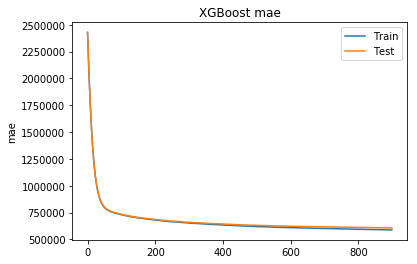

In [102]:
results = model.evals_result()
display("Maxima diferencia al final: " + str(results['validation_1']['mae'][-1] - results['validation_0']['mae'][-1]))
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('mae')
plt.title('XGBoost mae')

In [ ]:
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
param_dist = {'n_estimators': stats.randint(600, 2000),
              'learning_rate': stats.uniform(0.01, 0.1),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [3, 4, 5, 6]
             }
model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, eval_metric = "mae")
clf = RandomizedSearchCV(model, param_distributions = param_dist, n_iter = 5, error_score = 0, verbose = 3)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

entrenamiento = df.head(240000).copy()
X = entrenamiento[features].copy()
y = entrenamiento.precio.copy()
estimators = []
results = np.zeros(len(train_x))
score = 0.0
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    x_train_procesado = preprocessor.fit_transform(X_train)
    x_val_procesado = preprocessor.fit_transform(X_test)
#    my_pipeline.fit(X_train, y_train)
    clf.fit(x_train_procesado, y_train)

    estimators.append(clf.best_estimator_)
#    estimators.append(my_pipeline)
#    results[test_index] = my_pipeline.predict(X_test)
    results[test_index] = clf.predict(x_val_procesado)
    score += mean_absolute_error(y_test, results[test_index])
score /= numFolds
ping()
score

In [ ]:
mean_absolute_error(results, y)

In [ ]:
estimators